In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_geom_median import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 10
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_data['rho'] = 0.01

# PG-EXTRA hyperparameters
problem_data['alpha'] = 2.5
problem_data['itr_num'] = 1000

{'n_node': 6, 'vector_size': 10}


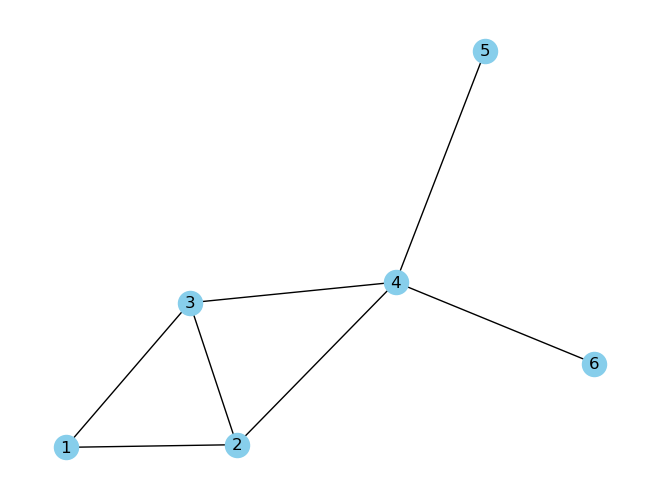

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=429.57856244883726, np.linalg.norm(x_opt_star)=257.1379058175132


In [5]:
# assert np.allclose(f_cvx, f_star) and np.linalg.norm(x_cvx - x_opt_star, ord='fro') < 1e-8, print(f_cvx, f_star)

In [6]:
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']

prox_operators = []
fi_operators = []

for jj in range(n_node):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    prox_operators += [lambda z, alpha, bj=bj:  cvx_prox_fj_geom_mean(z, alpha, bj, vector_size)]
    fi_operators += [lambda x_kj, bj=bj: 1/2*np.linalg.norm((x_kj - bj), ord=2)]

In [12]:
params={"R":18, "Inductance":5, "Capacitance":1, "h":0.5425477172429249}
_ = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True)

ii=0, f_reldiff[-1]=0.20459999558245143, err_opt_reldiff[-1]=0.9748890170913419
ii=50, f_reldiff[-1]=0.1246045703952946, err_opt_reldiff[-1]=0.7023348134199934
ii=100, f_reldiff[-1]=0.06131599051151896, err_opt_reldiff[-1]=0.482934253811228
ii=150, f_reldiff[-1]=0.02823469540529876, err_opt_reldiff[-1]=0.32575643721122893
ii=200, f_reldiff[-1]=0.012577670408586731, err_opt_reldiff[-1]=0.2182395991842237
ii=250, f_reldiff[-1]=0.005545113993859103, err_opt_reldiff[-1]=0.14659808942383545
ii=300, f_reldiff[-1]=0.002459364853649788, err_opt_reldiff[-1]=0.09946152511767882
ii=350, f_reldiff[-1]=0.00111144115871811, err_opt_reldiff[-1]=0.06854123864969824
ii=400, f_reldiff[-1]=0.0005172270192267162, err_opt_reldiff[-1]=0.048161062107686524
ii=450, f_reldiff[-1]=0.0002499280866815672, err_opt_reldiff[-1]=0.03456696974740335
ii=500, f_reldiff[-1]=0.00012602127241560625, err_opt_reldiff[-1]=0.025332900373617646
ii=550, f_reldiff[-1]=6.638850087929925e-05, err_opt_reldiff[-1]=0.01891868227370686

In [13]:
params={"R":18, "Inductance":10, "Capacitance":10, "h":1.1084297706164639}
_ = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True)

ii=0, f_reldiff[-1]=0.20459999558245143, err_opt_reldiff[-1]=0.9748890170913419
ii=50, f_reldiff[-1]=0.2014716051522505, err_opt_reldiff[-1]=0.9247990024865176
ii=100, f_reldiff[-1]=0.16767264718311578, err_opt_reldiff[-1]=0.8375735533472988
ii=150, f_reldiff[-1]=0.1424488666555802, err_opt_reldiff[-1]=0.7657107447098835
ii=200, f_reldiff[-1]=0.12003035565287258, err_opt_reldiff[-1]=0.69783908648657
ii=250, f_reldiff[-1]=0.10044385363729053, err_opt_reldiff[-1]=0.634470174527372
ii=300, f_reldiff[-1]=0.08360846718204526, err_opt_reldiff[-1]=0.5758246805095191
ii=350, f_reldiff[-1]=0.069245639074277, err_opt_reldiff[-1]=0.5217338714574105
ii=400, f_reldiff[-1]=0.05709195045498566, err_opt_reldiff[-1]=0.472048916420604
ii=450, f_reldiff[-1]=0.04688419452449096, err_opt_reldiff[-1]=0.42658215628545193
ii=500, f_reldiff[-1]=0.038368141039732316, err_opt_reldiff[-1]=0.38511583065377014
ii=550, f_reldiff[-1]=0.03130643754536345, err_opt_reldiff[-1]=0.3474120155000718
ii=600, f_reldiff[-1]=0.

In [33]:
params={"R":18, "Inductance":10, "Capacitance":1, "h":1.0541046971920436}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.20459999558245143, err_opt_reldiff[-1]=0.9748890170913419
ii=200, f_reldiff[-1]=0.002069334919211927, err_opt_reldiff[-1]=0.09165645697099749
ii=400, f_reldiff[-1]=2.8595427958484812e-05, err_opt_reldiff[-1]=0.012804007302271382
ii=600, f_reldiff[-1]=1.2158337225308072e-06, err_opt_reldiff[-1]=0.002734696812786927
ii=800, f_reldiff[-1]=7.029563673391317e-08, err_opt_reldiff[-1]=0.0005965057092174397
ii=999, f_reldiff[-1]=4.155017996838906e-09, err_opt_reldiff[-1]=0.00011074011417583643


In [37]:
params={"R":50, "Inductance":10, "Capacitance":1, "h":0.3978152934397974}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.14096212334035643, err_opt_reldiff[-1]=0.9367874436764204
ii=200, f_reldiff[-1]=0.014033435421249017, err_opt_reldiff[-1]=0.2542786689863742
ii=400, f_reldiff[-1]=0.0005685780266753656, err_opt_reldiff[-1]=0.06204213044941468
ii=600, f_reldiff[-1]=3.36122627705816e-05, err_opt_reldiff[-1]=0.019352653581468017
ii=800, f_reldiff[-1]=5.283403836011265e-06, err_opt_reldiff[-1]=0.007446130158350104
ii=999, f_reldiff[-1]=2.2282742427449175e-06, err_opt_reldiff[-1]=0.0031204447534252705


In [34]:
R = 50
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.14096212334035643, err_opt_reldiff[-1]=0.9367874436764204
ii=200, f_reldiff[-1]=6.072878203308759e-09, err_opt_reldiff[-1]=0.00011191100703038907
ii=400, f_reldiff[-1]=1.267859001575393e-09, err_opt_reldiff[-1]=6.391337625178859e-05
ii=600, f_reldiff[-1]=2.9850701865991353e-10, err_opt_reldiff[-1]=6.392514117863494e-05
ii=800, f_reldiff[-1]=8.184908069610233e-11, err_opt_reldiff[-1]=6.385577123781763e-05
ii=999, f_reldiff[-1]=1.8890238318198049e-10, err_opt_reldiff[-1]=6.383305062306272e-05


In [ ]:
params={"R":18, "Inductance":10, "h":1.1054814693822324}
ciradmm_err_opt_star, ciradmm_err_opt_reldiff, ciradmm_const_vio, ciradmm_f_reldiff = co.dadmm("cir_dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

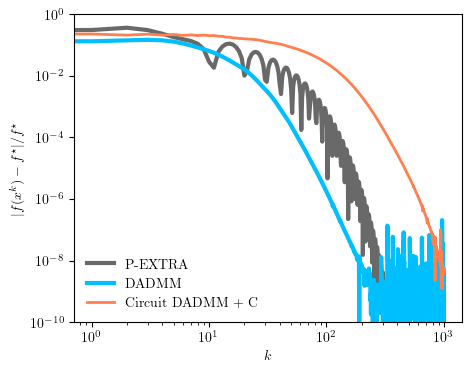

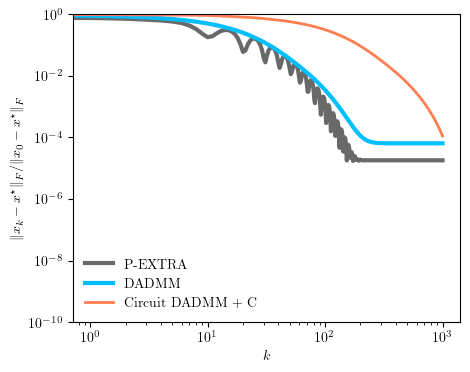

In [36]:
# apply P-EXTRA 
problem_data['alpha'] = 50
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star,)

fname = "n6_circuit_dadmm_c"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'gold'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=3)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=3)
# plt.plot(ciradmm_f_reldiff, label='Circuit DADMM',  color=green, linewidth=2)
plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/f^\star$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-10, 1e0)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)

plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_err_opt_reldiff, label='P-EXTRA', color=black, linewidth=3)
plt.plot(admm_err_opt_reldiff, label='DADMM', color=blue, linewidth=3)
# plt.plot(admm_err_opt_reldiff, label='Circuit DADMM', color=green, linewidth=2)
plt.plot(dadmm_c_err_opt_reldiff, label='Circuit DADMM + C', color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$\|x_k - x^\star\|_F /\|x_0 - x^\star\|_F $")
plt.ylim(1e-10, 1e0)
plt.legend()
plt.savefig(f'plots/xreldif_{fname}.pdf', dpi=300)